# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [1]:
import pickle
import pandas as pd
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
import PIL
from PIL import Image
from pathlib import Path

import torch
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
#!unzip -q '/content/drive/MyDrive/Colab Notebooks/projects/Stepik_mfti_deep_learning_1_sem/14_1_Homework_Simpsons_classifier/journey-springfield.zip'

In [3]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

PATH = '/content/drive/MyDrive/Colab Notebooks/projects/Stepik_mfti_deep_learning_1_sem/14_1_Homework_Simpsons_classifier/'

if torch.cuda.is_available():
    device = torch.device('cuda') #torch.device('cuda:0')
    print('GPU available')
else:
    device = torch.device('cpu')
    print('CPU available')

DEVICE = device

GPU available


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p=0.7),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomRotation(degrees=(-15, 15)),
                transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
#определим директории с тренировочными и тестовыми файлами

# TRAIN_DIR = Path(PATH + 'journey-springfield/train')
# TEST_DIR = Path(PATH +'journey-springfield/testset')

# TRAIN_DIR = Path('./train/')
# TEST_DIR = Path('./testset')
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset')

In [7]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [10]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

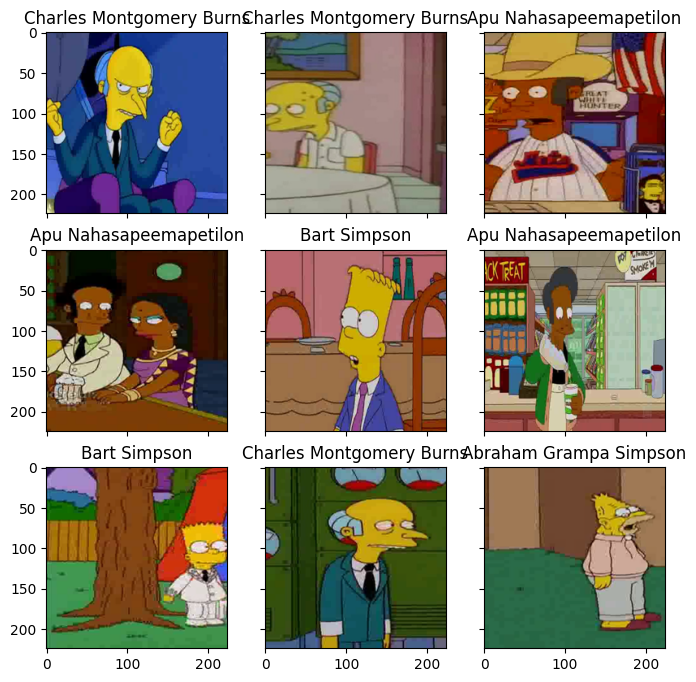

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [12]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8*2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8*2, out_channels=16*2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16*2, out_channels=32*2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32*2, out_channels=64*2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64*2, out_channels=96*2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96*2 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [13]:
# Доработанная сеть
class Cnn(SimpleCnn):

    def __init__(self, n_classes):
        super(Cnn, self).__init__(n_classes)
        self.conv1.add_module('bn1', nn.BatchNorm2d(8*2))

        self.conv2.add_module('bn2', nn.BatchNorm2d(16*2))

        self.conv3.add_module('bn3', nn.BatchNorm2d(32*2))

        self.conv4.add_module('bn4', nn.BatchNorm2d(64*2))

        self.conv5.add_module('bn5', nn.BatchNorm2d(96*2))

        self.fc1 = nn.Sequential(
            nn.Linear(96*2 * 5 * 5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            #nn.Dropout(0.5)
        )

        self.out = nn.Linear(2048, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.out(x)
        return logits

In [14]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
#         probs = nn.functional.softmax(outputs, dim=1)  # Применяем softmax к выходам модели
#         preds = torch.argmax(probs, dim=1)  # Получаем предсказания модели

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [15]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [16]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            scheduler.step()

    return history

In [17]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [18]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = Cnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
Cnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, p

Запустим обучение сети.

In [19]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [27]:
%%time
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=128)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.2813751409901077


epoch:   5%|▌         | 1/20 [05:47<1:50:00, 347.41s/it]


Epoch 001 train_loss: 2.2814     val_loss 1.5690 train_acc 0.3809 val_acc 0.5657
loss 1.5961473900555456


epoch:  10%|█         | 2/20 [10:32<1:33:18, 311.01s/it]


Epoch 002 train_loss: 1.5961     val_loss 1.1504 train_acc 0.5590 val_acc 0.6848
loss 1.2121588953498579


epoch:  15%|█▌        | 3/20 [15:15<1:24:29, 298.19s/it]


Epoch 003 train_loss: 1.2122     val_loss 0.9150 train_acc 0.6611 val_acc 0.7468
loss 0.9592848783147147


epoch:  20%|██        | 4/20 [19:57<1:17:43, 291.48s/it]


Epoch 004 train_loss: 0.9593     val_loss 0.8619 train_acc 0.7327 val_acc 0.7696
loss 0.7946401452538283


epoch:  25%|██▌       | 5/20 [24:39<1:12:02, 288.19s/it]


Epoch 005 train_loss: 0.7946     val_loss 0.7632 train_acc 0.7748 val_acc 0.7996
loss 0.48579547052945643


epoch:  30%|███       | 6/20 [29:20<1:06:42, 285.87s/it]


Epoch 006 train_loss: 0.4858     val_loss 0.5882 train_acc 0.8611 val_acc 0.8487
loss 0.37873516001172247


epoch:  35%|███▌      | 7/20 [33:57<1:01:18, 282.93s/it]


Epoch 007 train_loss: 0.3787     val_loss 0.5765 train_acc 0.8901 val_acc 0.8552
loss 0.3053928672606736


epoch:  40%|████      | 8/20 [38:30<55:58, 279.86s/it]  


Epoch 008 train_loss: 0.3054     val_loss 0.5663 train_acc 0.9113 val_acc 0.8642
loss 0.26329177434265677


epoch:  45%|████▌     | 9/20 [43:09<51:12, 279.36s/it]


Epoch 009 train_loss: 0.2633     val_loss 0.5628 train_acc 0.9238 val_acc 0.8689
loss 0.23279992888190806


epoch:  50%|█████     | 10/20 [47:48<46:32, 279.21s/it]


Epoch 010 train_loss: 0.2328     val_loss 0.5871 train_acc 0.9338 val_acc 0.8701
loss 0.17488606556983305


epoch:  55%|█████▌    | 11/20 [52:24<41:45, 278.37s/it]


Epoch 011 train_loss: 0.1749     val_loss 0.5384 train_acc 0.9490 val_acc 0.8804
loss 0.14768080695627359


epoch:  60%|██████    | 12/20 [57:06<37:14, 279.36s/it]


Epoch 012 train_loss: 0.1477     val_loss 0.5397 train_acc 0.9574 val_acc 0.8856
loss 0.1307702520101099


epoch:  65%|██████▌   | 13/20 [1:01:51<32:48, 281.20s/it]


Epoch 013 train_loss: 0.1308     val_loss 0.5535 train_acc 0.9644 val_acc 0.8850
loss 0.12999739064884547


epoch:  70%|███████   | 14/20 [1:06:38<28:17, 282.87s/it]


Epoch 014 train_loss: 0.1300     val_loss 0.5537 train_acc 0.9632 val_acc 0.8821
loss 0.12762189262159632


epoch:  75%|███████▌  | 15/20 [1:11:23<23:38, 283.60s/it]


Epoch 015 train_loss: 0.1276     val_loss 0.5576 train_acc 0.9638 val_acc 0.8829
loss 0.10915575868903517


epoch:  80%|████████  | 16/20 [1:16:09<18:56, 284.19s/it]


Epoch 016 train_loss: 0.1092     val_loss 0.5396 train_acc 0.9687 val_acc 0.8846
loss 0.10292412553114742


epoch:  85%|████████▌ | 17/20 [1:20:52<14:11, 283.86s/it]


Epoch 017 train_loss: 0.1029     val_loss 0.5341 train_acc 0.9704 val_acc 0.8865
loss 0.09444087242782477


epoch:  90%|█████████ | 18/20 [1:25:34<09:27, 283.51s/it]


Epoch 018 train_loss: 0.0944     val_loss 0.5385 train_acc 0.9742 val_acc 0.8907
loss 0.0956390245432413


epoch:  95%|█████████▌| 19/20 [1:30:17<04:43, 283.33s/it]


Epoch 019 train_loss: 0.0956     val_loss 0.5459 train_acc 0.9731 val_acc 0.8844
loss 0.10322076972417144


epoch: 100%|██████████| 20/20 [1:35:03<00:00, 285.15s/it]


Epoch 020 train_loss: 0.1032     val_loss 0.5412 train_acc 0.9705 val_acc 0.8882
CPU times: user 2h 50min 22s, sys: 4min 12s, total: 2h 54min 35s
Wall time: 1h 35min 3s


Построим кривые обучения

In [28]:
loss, acc, val_loss, val_acc = zip(*history)

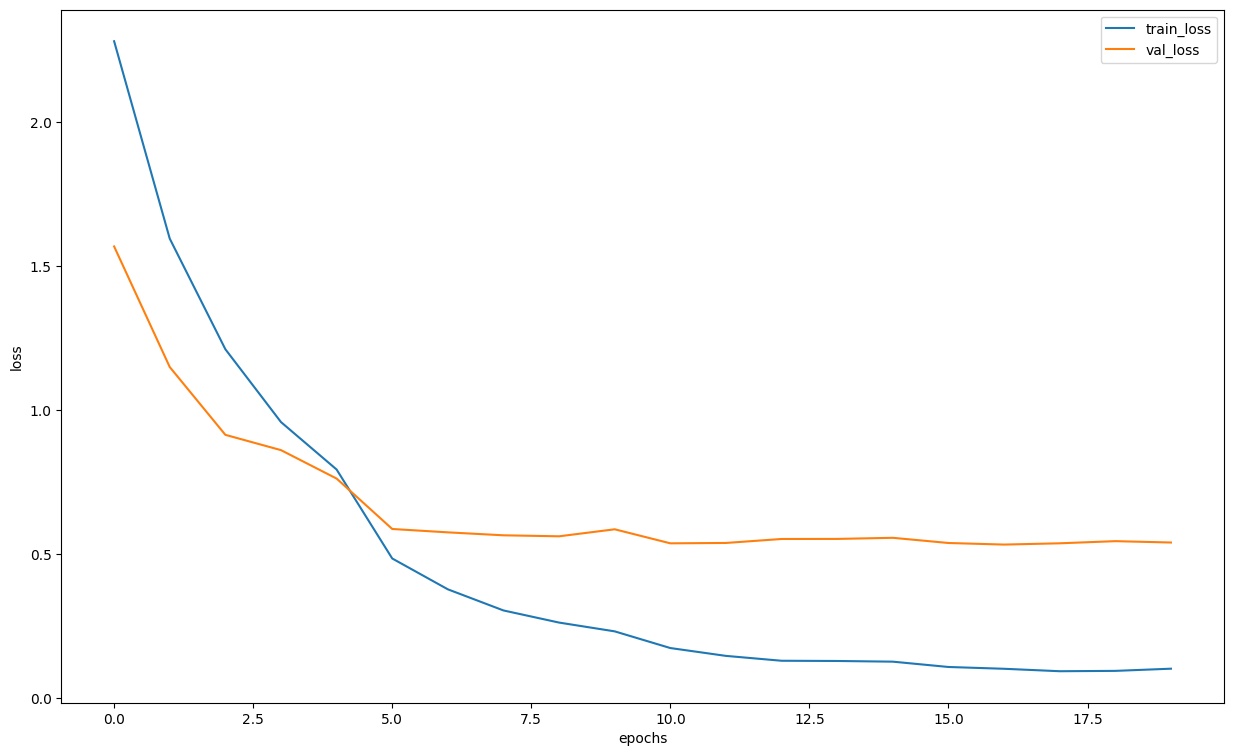

In [29]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [30]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [31]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [32]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [33]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [34]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [35]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9


In [46]:
torch.save(simple_cnn.state_dict(), 'cnn_simpsons_clissiffier_state_dict.pth')

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

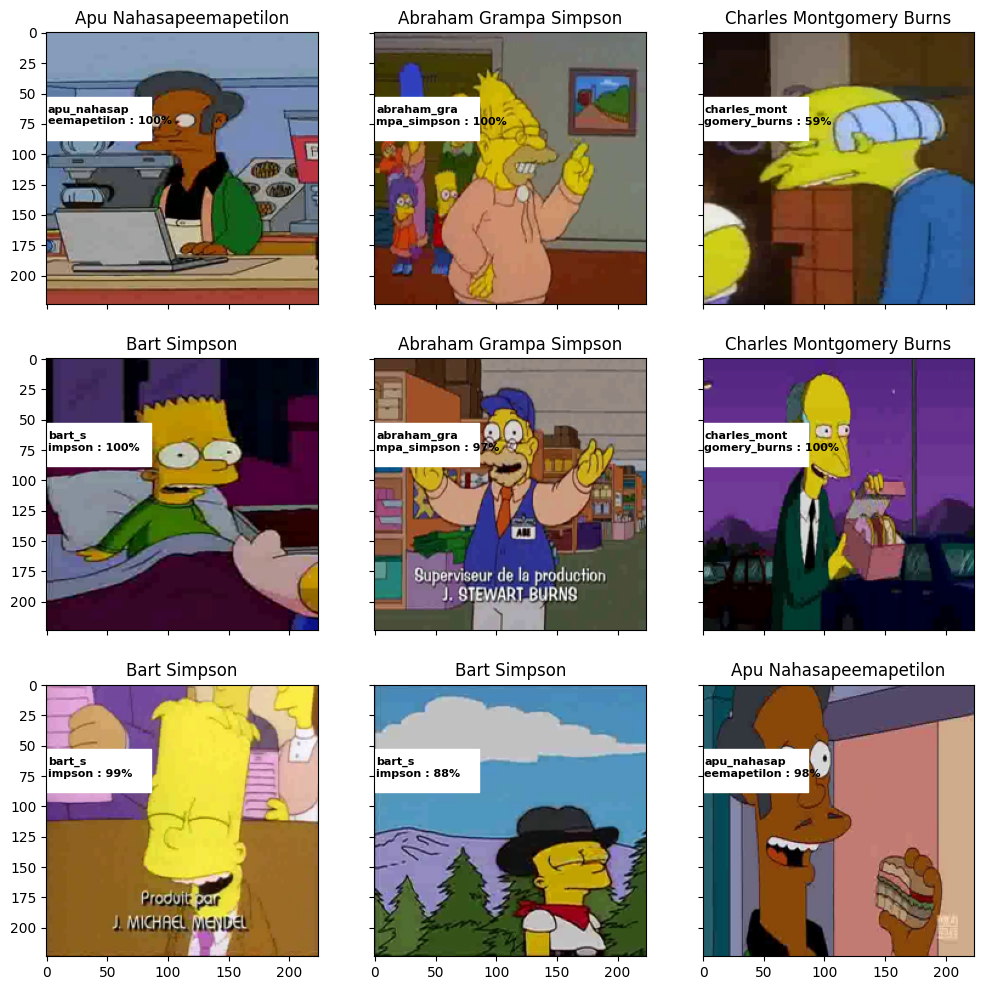

In [36]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [37]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [38]:
! ls

label_encoder.pkl


In [43]:
#my_submit = pd.read_csv("/content/sample_submission.csv") 
#my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv") #/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [40]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [44]:
my_submit.to_csv('submit_simpsons_cnn.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
